In [24]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import keras_tuner as kt
from keras_tuner import RandomSearch
from tensorflow.keras import layers, models

In [47]:
# Path to your zip file
zip_file = 'histopathologic-cancer-detection.zip'

# Extract all files
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('.')  


In [52]:
# Load CSV files
train_labels = pd.read_csv('train_labels.csv')
sample_submission = pd.read_csv('sample_submission.csv')


In this project, the challenge is to buil a Convolutionla Neural Network(CNN) model that can classify histopathologic images into label 0(benign) and label 1(malignant).
I just downloaded the files so now it's time to explore the raw data.

In [3]:
#Structure of the train_labels
print(train_labels.head())
print('-------------------------------------------------------')

#Size of the train_labels
print(train_labels.shape)
print('-------------------------------------------------------')

#Chekcing Null data
print(train_labels.info())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
-------------------------------------------------------
(220025, 2)
-------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None


The size of train_labels data is 220025 rows and 2 columns. There is no Null value.
train_labels is the output of train folder.

Let's also check the size of test folder.

In [4]:
#Szie of test folder
test_folder = 'test/'
image_files = os.listdir(test_folder)
print(len(image_files))

57458


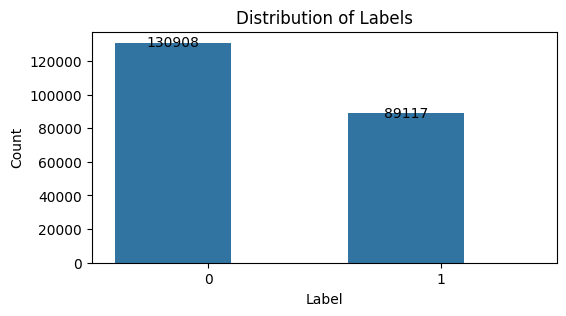

In [5]:
#Data Visualization
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=train_labels, x='label')

for bar in ax.patches:
    bar.set_width(0.5) 

for p in ax.patches:
    count = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2, count + 0.5, str(count), ha='center', va='center') 
    
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

The histogram above is to see the distribution of labels in train_label. There are 130908 number of images 
that are labeled as 0 (benign) and 89117 images that are labeled as 1(malignant).
We can see that this data is imbalanced and this might overfit to the majority class, which is label 0, if the 
data is not handled properly. 

Now, I want to check out some actual images those are labeled as 0 and 1.

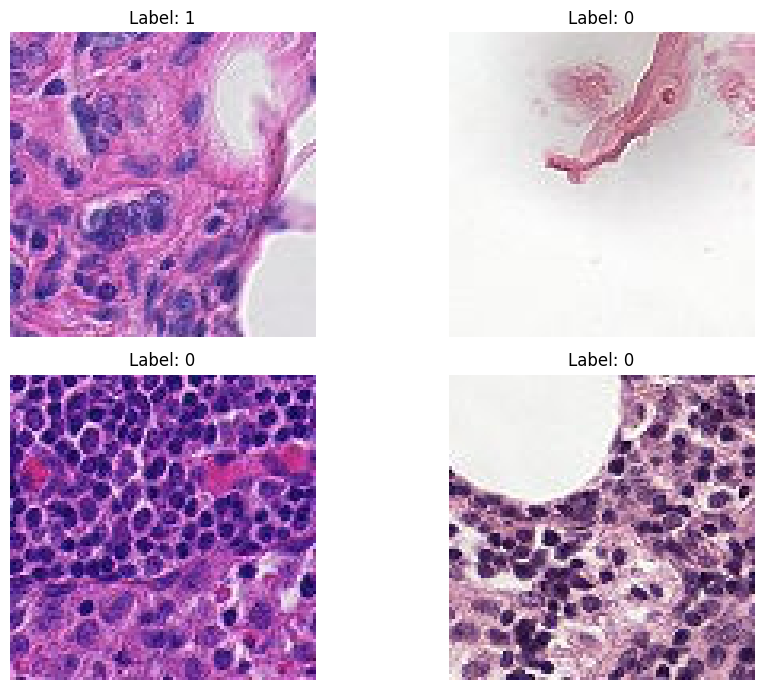

In [6]:
# Visualize a few images with labels
img_dir = './train'  

sample_images = train_labels.sample(4)
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

for i, img_id in enumerate(sample_images['id']):
    img_path = os.path.join(img_dir, f"{img_id}.tif")
    img = Image.open(img_path)
    ax[i // 2, i % 2].imshow(img)
    ax[i // 2, i % 2].set_title(f"Label: {sample_images.iloc[i]['label']}")
    ax[i // 2, i % 2].axis('off')

plt.tight_layout()
plt.show()

Before building any CNN model, preprocessing step is needed.

In [7]:
#Resize images
img_size = (64, 64)
batch_size = 32

#Preprocess images (grayscale or other format images to RGB)
def tiff_to_rgb(img):
    if img.shape[-1] != 3:  
        img = tf.image.grayscale_to_rgb(img)
    return img

train_data_generator = ImageDataGenerator(validation_split=0.2, preprocessing_function= tiff_to_rgb)

I just processed the original raw images to RBG format and then in the cell below, I am going to create
the generator for training and validation sets.

In [8]:
#Generator for training and validation data sets
train_labels['id'] = train_labels['id'].str.replace(".tif$", "") + ".tif"

def create_generator(datagen: ImageDataGenerator, subset: str):
    return datagen.flow_from_dataframe(directory= img_dir, dataframe=train_labels, x_col='id', y_col='label',
                                       subset=subset, seed=123, shuffle= True, target_size = img_size, batch_size=batch_size,
                                       class_mode='binary')
    
#Converting the 'labels' to str type before running the data through the create_generator function
train_labels['label'] = train_labels['label'].astype(str)

train_generator = create_generator(train_data_generator, "training")
validation_generator = create_generator(train_data_generator, "validation")

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Time to build a CNN model. The architecture includes convolutional layers, pooling layers, dense layers, dropout layers
and batch normalization layers.

In [13]:
# CNN Model 1 before any hyperparameter tuning
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


First CNN model, before any hyperparemeter tuning, here are the values.
32, 64, 128 are number of filters. This progression of increasing filters allows the model to build a hierarchical
representation of the data.
Filter size is  3 by 3. I did not choose bigger filter because smaller filter detect local patterns better.
ReLu is chosen for the activation function is usually used for non-linearity and mitigates vanishing gradient problem.
2 by 2 is used for MaxPooling which reduces dimensionality and computational complexity while retaining the important features.
2 by 2 is standard choice so I started with it. 
BatchNormalization function was added to the convolutional layers to converge faster and reduce the risk of overfitting. 
Usually, this function works well with ReLu. 

In [14]:
# Flatten the feature maps (2D to 1D)
model.add(Flatten())

# Fully connected layer (Dense layer)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  

# Output Layer
model.add(Dense(1, activation='sigmoid'))  

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



128 is chosen for number of neurons in the dense layer because it's a common choice.
0.5 in the Dropout function means that 50% chance of dropping out a neuron.
'sigmoid' activation is chosen for the output layer because this activation function squashes the output into
a range between 0 and 1, which is suitable for binary classification problems like this.
'adam' is chosen for the optimizer because it's the combination of AdaGrad and RMSProp. It adapts the learning rate
during training and is effective for many types of neural networks.

In [15]:
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 31, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,225 (2.61 MB)

 Trainable params: 683,777 (2.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
#Fitting the model to training and validation data sets
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,  
    verbose=1)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 230s 42ms/step - accuracy: 0.8952 - loss: 0.2661 - val_accuracy: 0.8922 - val_loss: 0.2746
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 228s 41ms/step - accuracy: 0.9059 - loss: 0.2400 - val_accuracy: 0.8412 - val_loss: 0.4285
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 217s 39ms/step - accuracy: 0.9152 - loss: 0.2188 - val_accuracy: 0.8679 - val_loss: 0.3270
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 234s 42ms/step - accuracy: 0.9211 - loss: 0.2003 - val_accuracy: 0.9081 - val_loss: 0.2391
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 237s 43ms/step - accuracy: 0.9265 - loss: 0.1880 - val_accuracy: 0.8536 - val_loss: 0.4185


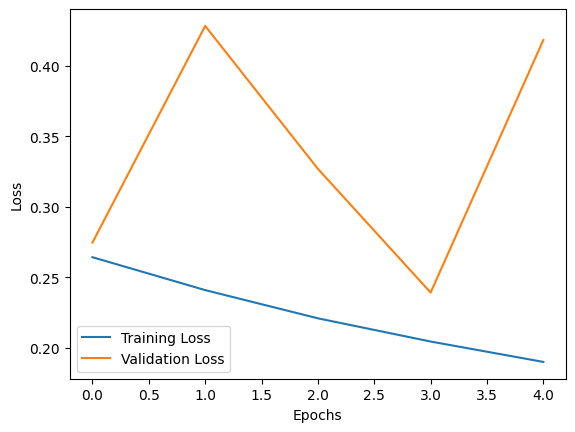

In [18]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

It is good that as epochs incearsed the loss of training data set is decreasing. During the training,
the training loss decreases because the model is improving its fit to the data.

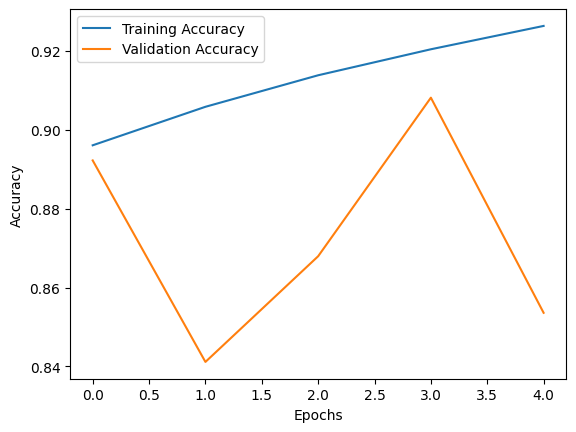

In [19]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The accuracy of training data is increasing as the model improves over each epochs.
However, the validation accuracy is still fluctuating. In order to fix this, we need some hyperparameter tuning.

In [29]:
#Hyperparameter tuning
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(hp.Int('filters', min_value=32, max_value=128, step=32), 
                            kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('units', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(build_model, objective='val_loss', max_trials=10)
tuner.search(train_generator, epochs=5, validation_data=validation_generator)

Trial 10 Complete [00h 09m 15s]
val_loss: 0.4410243332386017

Best val_loss So Far: 0.4410243332386017
Total elapsed time: 04h 54m 02s


In [32]:
#What are the best parameters?
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of filters: {best_hps.get('filters')}")
print(f"Best number of units: {best_hps.get('units')}")
print(f"Best optimizer: {best_hps.get('optimizer')}")

Best number of filters: 32
Best number of units: 192
Best optimizer: adam


In [34]:
#Train the model with the best parameters
best_model = tuner.hypermodel.build(best_hps)
history1 = best_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 106s 19ms/step - accuracy: 0.6881 - loss: 9.4341 - val_accuracy: 0.7009 - val_loss: 0.5666
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 106s 19ms/step - accuracy: 0.7539 - loss: 0.5173 - val_accuracy: 0.7876 - val_loss: 0.4802
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 106s 19ms/step - accuracy: 0.7845 - loss: 0.4756 - val_accuracy: 0.7647 - val_loss: 0.5088
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 106s 19ms/step - accuracy: 0.7925 - loss: 0.4539 - val_accuracy: 0.7568 - val_loss: 0.5105
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 106s 19ms/step - accuracy: 0.8037 - loss: 0.4316 - val_accuracy: 0.7807 - val_loss: 0.4916


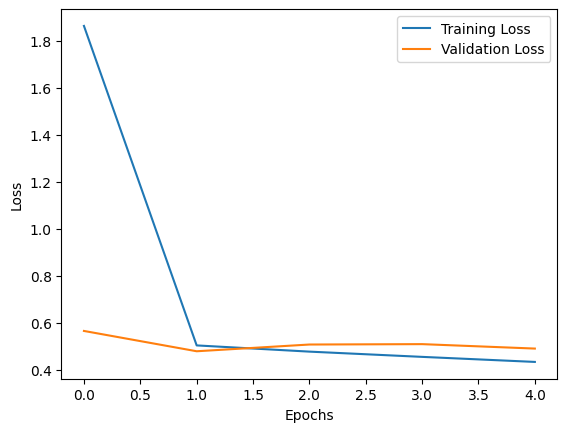

In [36]:
# Plot training and validation loss after hyperparameter tuning
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The values that I got from the hyperparameter worked.
The training loss decreases as epochs increases and the validation loss is not fluctuating as much as before.

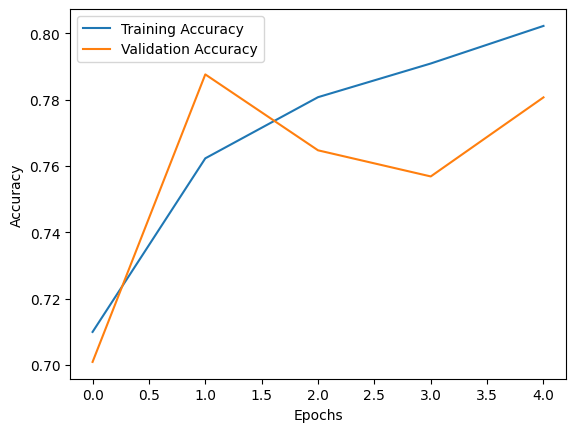

In [37]:
# Plot training and validation accuracy
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The training accuracy increase as epochs increases, which is good. The validation accuracy is fluctuating
little bit but not as much as before hyperparameter tuning. This is better!

The original values: filters = 32, 64, 128, dense layer = 128, optimizer = adam.
The updated values: filters = 32, dense layer = 192, optimizer = adam.

The improved dense layer capacity and effective oprimizer contributed to better generalization, 
but some validation fluctuations persisted, possibly due to limited trials, noise in the data or complexity.
To enhance stability and performance further, extended hyperparameter tuning, data augmentation and 
regularization technique are needed.

In [53]:
#Final step: fit test data to the trained model
img_dir_test = './test' 

sample_submission['id'] = sample_submission['id'].str.replace(".tif$", "") + ".tif"

sample_submission['label'] = sample_submission['label'].astype(str)

test_data_generator = ImageDataGenerator(preprocessing_function= tiff_to_rgb)

test_generator = test_data_generator.flow_from_dataframe(dataframe= sample_submission, directory =img_dir_test,
                                                         x_col='id', y_col='label', target_size= img_size, 
                                                         batch_size= batch_size, class_model='binary', shuffle=False)

Found 57458 validated image filenames belonging to 1 classes.


In [56]:
#Prediction
prediction = best_model.predict(test_generator, verbose=1)
label_pred = np.where(prediction > 0.5, 1, 0)
print(label_pred)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [0]]


In [60]:
#Preparing submission file for the competition
submission = sample_submission.copy()
submission.label = label_pred
print(submission.head())

submission.to_csv('submission.csv', header = True, index = False)

                                             id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif      0
1  95596b92e5066c5c52466c90b69ff089b39f2737.tif      1
2  248e6738860e2ebcf6258cdc1f32f299e0c76914.tif      0
3  2c35657e312966e9294eac6841726ff3a748febf.tif      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif      0


Conclusion: The hyperparameter optimization significanlty improved the performance of the CNN model
by updating the number of filters, dense units and oprimizer. The original model before any hyperparameter
tuning, the accruacy of training data is around 0.91. After the tuning, it is 0.80. Even though the accuracy
decreased, the fluctuating of validation accuracy got better. Based on this result, I assume there could have 
been overfitting on validation data before the tuning. 